In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.cross_decomposition import CCA



/home/mind/mrenaudi/.local/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-26 10:30:56.172499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 10:30:56.194798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 10:30:56.201516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 10:30:56.218940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorF

In [4]:
root = '.'
train_ratio = 1.0
test_ratio = 0.3

## Preprocessing for ridge regression and CCA

In [5]:
dataset_path = f"{root}/dataset_400parcels_3.nc"
targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

n_sub = len(dataset)
indices = np.arange(n_sub)

train_size = int(n_sub * (1 - test_ratio) * train_ratio)
test_size = int(test_ratio * n_sub)
run_size = test_size + train_size

random_state = np.random.RandomState(seed=42)
run_indices = random_state.choice(indices, run_size, replace=False)
train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()


## CV Ridge regression

In [6]:
ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

fitted_pipe = pipe_ridge.fit(X_train, y_train)

y_train_pred = fitted_pipe.predict(X_train)
y_test_pred = fitted_pipe.predict(X_test)



In [7]:
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

# Combine train and test results into a single DataFrame
results_ridge_df = pd.concat([train_results_df, test_results_df]).reset_index(drop=True)
results_ridge_df

,age,benton_faces,cardio_measure_pulse_mean,cardio_measure_bp_sys_mean,cardio_measure_bp_dia_mean,cattell,famous_faces,hotel_time,picture_priming_baseline_acc,picture_priming_baseline_rt,...,rt_choice_pred,rt_simple_pred,syn_sem_prop_error_pred,syn_sem_rt_pred,tip_of_tongue_pred,VSTM_colour_K_mean_pred,VSTM_colour_K_precision_pred,VSTM_colour_K_doubt_pred,VSTM_colour_MSE_pred,dataset
0,61.0,24.0,70.0,114.0,74.5,33.0,0.950000,291.309998,0.795238,899.0,...,0.685574,0.581069,0.122808,1765.596924,0.657142,2.000680,0.590643,46.230064,2346.054443,train
1,34.0,25.0,64.5,102.5,67.5,36.0,1.000000,480.000000,0.842857,886.0,...,0.588591,0.377661,0.071430,1820.000122,0.000003,2.239262,0.563594,8.501884,1532.454468,train
2,69.0,21.0,72.0,128.5,73.5,26.0,0.810345,380.279999,0.595238,798.0,...,0.784933,0.591138,0.214285,1520.999390,0.914281,1.647090,0.402744,15.524997,3887.708496,train
3,78.0,21.0,88.5,136.0,81.5,38.0,0.964286,193.220001,0.780952,880.0,...,0.555048,0.354173,0.047621,1587.300659,0.257146,2.219351,0.384937,35.581951,2316.064697,train
4,54.0,24.0,66.5,120.0,75.5,23.0,0.933333,480.000000,0.866667,907.0,...,0.617227,0.361150,0.072683,1919.297729,0.472223,1.518454,0.630216,9.526854,4299.219238,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,32.0,23.0,70.0,95.5,66.5,35.0,0.983333,240.000000,0.795238,854.0,...,0.544469,0.349463,0.167768,1520.072144,0.493746,2.225847,0.471387,31.900906,2014.353760,test
347,45.0,24.0,89.5,132.5,82.5,35.0,0.982759,106.220001,0.866667,787.0,...,0.534521,0.321983,0.261273,1321.757690,0.298498,1.970203,0.465262,24.010653,2626.443359,test
348,29.0,21.0,73.5,110.5,81.0,37.0,1.000000,223.779999,0.852381,725.0,...,0.499963,0.314857,0.211423,1448.266479,0.264246,2.055787,0.504039,19.895662,2451.148926,test
349,36.0,25.0,54.5,133.5,70.0,38.0,0.950000,254.720001,0.904762,910.0,...,0.557632,0.385590,0.241443,1653.052368,0.603134,2.206059,0.436584,30.188442,2106.095215,test


## CCA


In [8]:
# Define the pipeline with CCA
n_components = min(len(targets), X_train.shape[1])  # CCA components <= min(n_features, n_targets)

pipe_cca = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features and targets
    ('cca', CCA(n_components=n_components))
])

# Fit the pipeline
pipe_cca.fit(X_train, y_train)
cca_model = pipe_cca.named_steps['cca']


# Transform the data and predict
#X_train_cca, y_train_cca = cca_model.transform(X_train, y_train)  # Transform the features
#X_test_cca, y_test_cca = cca_model.transform(X_test, y_test) 

y_train_pred = cca_model.predict(X_train)
y_test_pred = cca_model.predict(X_test)



In [9]:
# Create result DataFrames
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

# Combine train and test results into a single DataFrame
results_cca_df = pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

# Display the results DataFrame
results_cca_df

,age,benton_faces,cardio_measure_pulse_mean,cardio_measure_bp_sys_mean,cardio_measure_bp_dia_mean,cattell,famous_faces,hotel_time,picture_priming_baseline_acc,picture_priming_baseline_rt,...,rt_choice_pred,rt_simple_pred,syn_sem_prop_error_pred,syn_sem_rt_pred,tip_of_tongue_pred,VSTM_colour_K_mean_pred,VSTM_colour_K_precision_pred,VSTM_colour_K_doubt_pred,VSTM_colour_MSE_pred,dataset
0,61.0,24.0,70.0,114.0,74.5,33.0,0.950000,291.309998,0.795238,899.0,...,0.555523,1.070855,0.455882,3065.152257,1.269368,0.927578,1.187267,132.277649,5252.716577,train
1,34.0,25.0,64.5,102.5,67.5,36.0,1.000000,480.000000,0.842857,886.0,...,0.357053,0.247800,0.185798,3463.409325,-1.534608,2.302807,0.971634,5.984203,444.739005,train
2,69.0,21.0,72.0,128.5,73.5,26.0,0.810345,380.279999,0.595238,798.0,...,1.161248,1.078842,0.708959,1574.282960,2.727247,-0.475799,0.381552,-3.441099,10507.201668,train
3,78.0,21.0,88.5,136.0,81.5,38.0,0.964286,193.220001,0.780952,880.0,...,0.505212,0.265304,0.183051,2769.927407,-0.530824,2.004604,0.152622,95.698701,4738.405927,train
4,54.0,24.0,66.5,120.0,75.5,23.0,0.933333,480.000000,0.866667,907.0,...,0.331096,0.453556,0.285561,4294.168454,0.308797,-1.176648,1.413736,19.194219,13861.872172,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,32.0,23.0,70.0,95.5,66.5,35.0,0.983333,240.000000,0.795238,854.0,...,0.290336,0.155342,0.441440,1485.539344,0.368742,2.289300,0.651425,78.230238,1793.119375,test
347,45.0,24.0,89.5,132.5,82.5,35.0,0.982759,106.220001,0.866667,787.0,...,0.225798,0.078347,0.875274,1109.495623,-0.337639,1.287723,0.546633,52.719336,4482.630995,test
348,29.0,21.0,73.5,110.5,81.0,37.0,1.000000,223.779999,0.852381,725.0,...,0.104520,0.149796,0.686839,1706.517107,-0.498033,1.341559,0.736995,46.748246,4927.760321,test
349,36.0,25.0,54.5,133.5,70.0,38.0,0.950000,254.720001,0.904762,910.0,...,0.321525,0.347522,0.861293,2413.074132,0.736329,2.236107,0.400639,71.646149,2714.737581,test


## Our model

In [10]:
#exp_name = "log transformation,  19 targets, batch size 32, 3 augmentations, non linear decoder 2"
exp_name = "strong pretraining, 3 layer decoder, 19 targets, 3 augmentations"
prediction_model = pd.read_csv("results/strong pretraining, 3 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

## Plotting

/tmp/ipykernel_3111228/2582738236.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


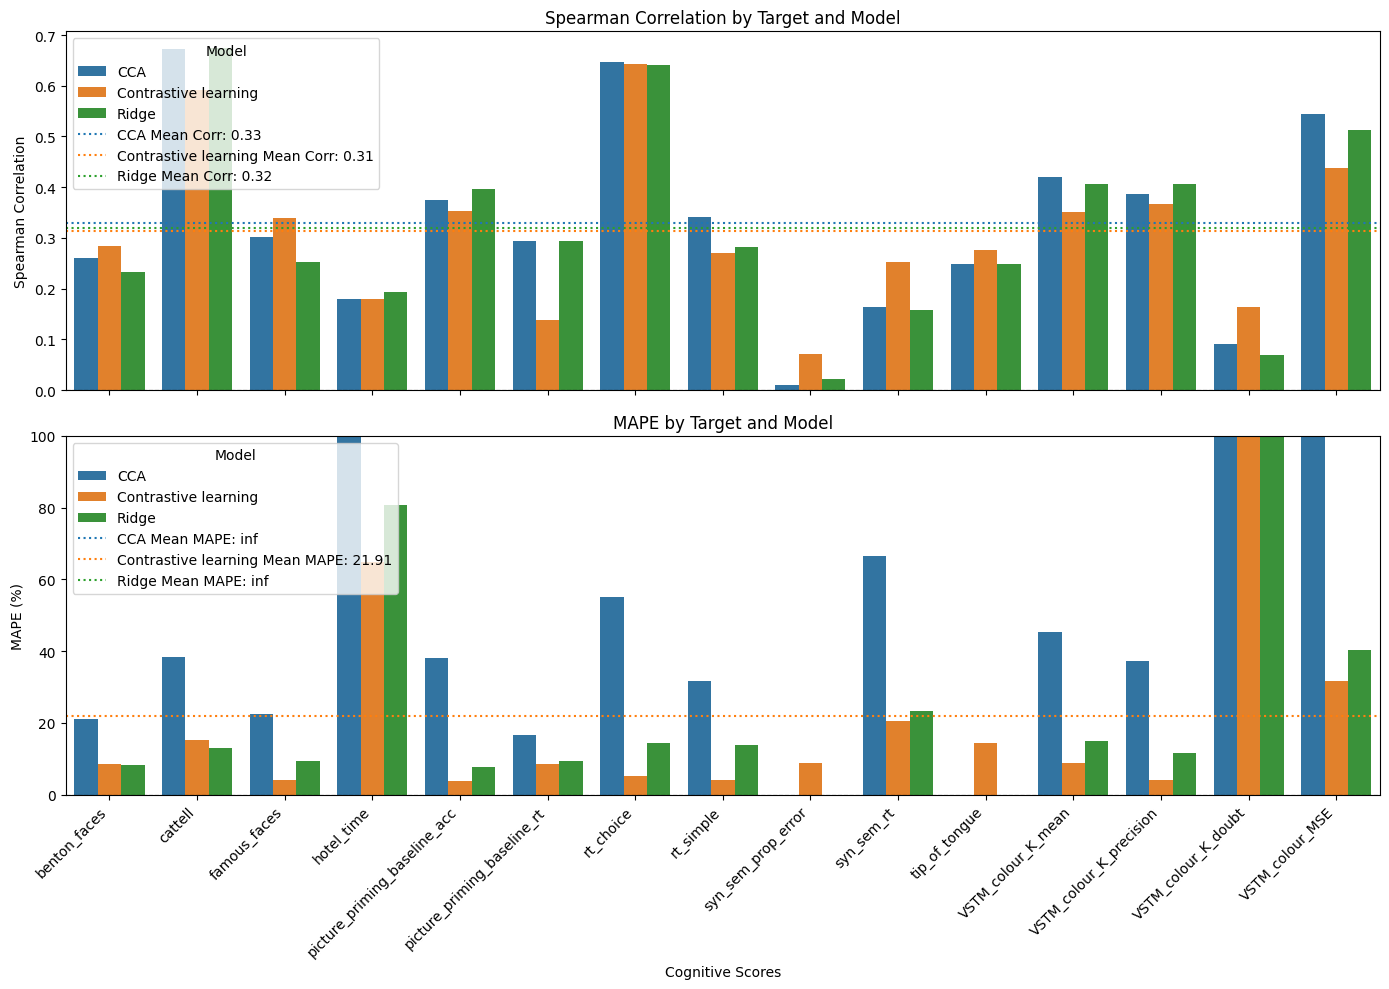

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():

                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute mean correlation and MAPE for each model
mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].mean().reset_index()
mean_stats.rename(columns={"spearman_corr": "mean_corr", "mape": "mean_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(mean_stats["model"])
}
for model, row in mean_stats.iterrows():
    axes[0].axhline(
        row["mean_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Mean Corr: {row['mean_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean MAPE
for model, row in mean_stats.iterrows():
    axes[1].axhline(
        row["mean_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Mean MAPE: {row['mean_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()

/tmp/ipykernel_3231453/3150955605.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


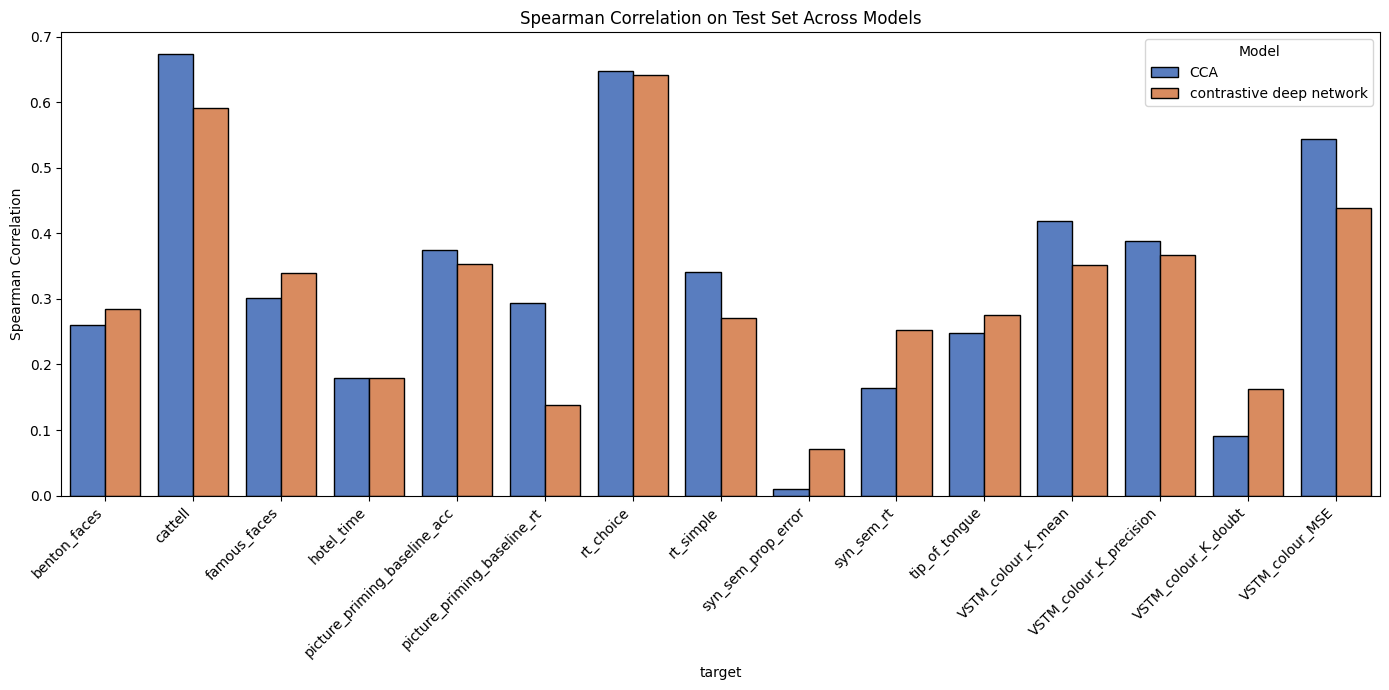

In [19]:
# Add model name to DataFrames
results_df["model"] = "CCA"
prediction_model["model"] = "contrastive deep network"

# Combine the two DataFrames
combined_df = pd.concat([results_df, prediction_model]).reset_index(drop=True)
test_df = combined_df[combined_df["dataset"] == "test"]

# List of targets to exclude
exclude_targets = ["age"] + [col for col in results_df.columns if "cardio_measure" in col and not col.endswith("_pred")]

# Calculate Spearman correlations for each target and model (only test data)
spearman_results = []

for target in [col for col in results_df.columns if not col.endswith("_pred") and col not in ["dataset", "model"]]:
    if target in exclude_targets:
        continue  # Skip targets that should be excluded
    
    for model in test_df["model"].unique():
        subset = test_df[test_df["model"] == model]
        corr, _ = spearmanr(subset[target], subset[f"{target}_pred"])
        spearman_results.append({"target": target, "model": model, "spearman_corr": corr})

# Create a DataFrame for plotting
spearman_df = pd.DataFrame(spearman_results)

# Plotting with Seaborn
plt.figure(figsize=(14, 7))
sns.barplot(
    data=spearman_df,
    x="target", y="spearman_corr", hue="model",
    ci="sd",  # Standard deviation for error bars
    palette="muted",
    edgecolor="black",
    dodge=True
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Spearman Correlation")
plt.title("Spearman Correlation on Test Set Across Models")
plt.legend(title="Model")
plt.tight_layout()

# Save and show plot
plt.savefig("spearman_correlation_test_only_excluding_age_cardio.png")
plt.show()

/tmp/ipykernel_3231453/1455040752.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


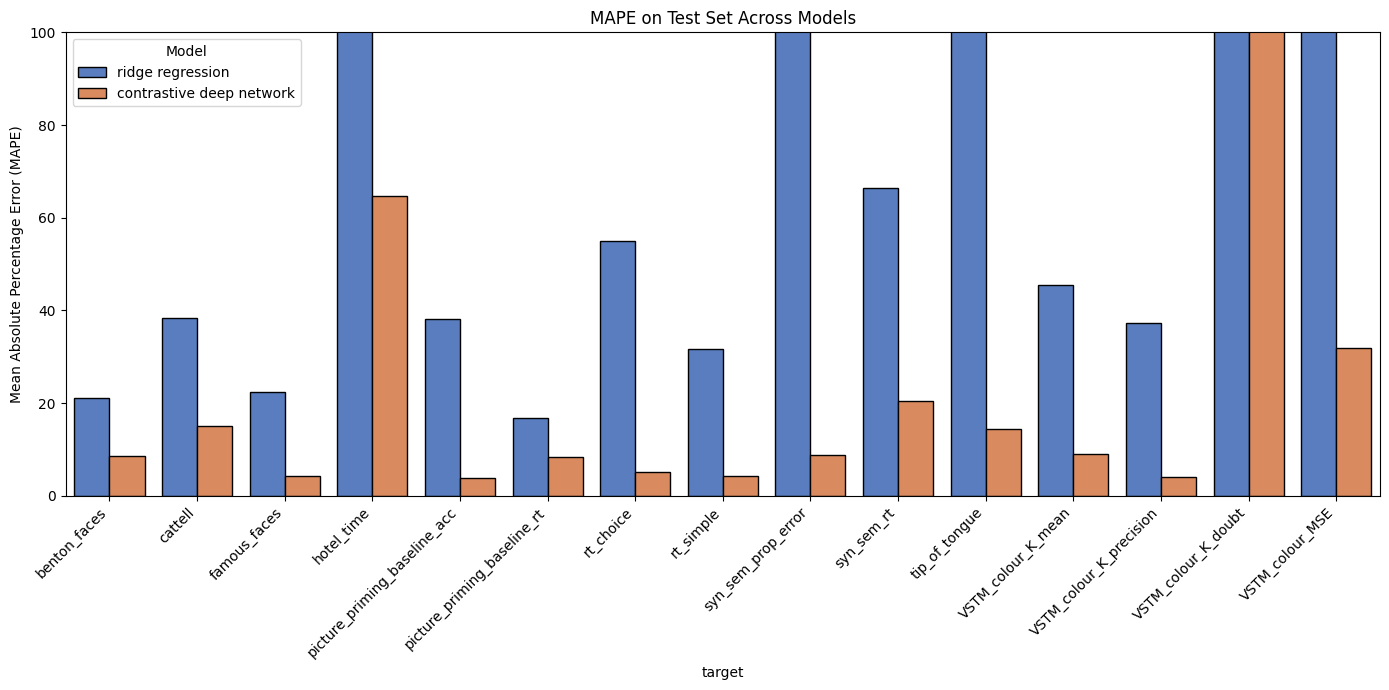

In [20]:
# Add model name to DataFrames
results_df["model"] = "ridge regression"
prediction_model["model"] = "contrastive deep network"

# Combine the two DataFrames
combined_df = pd.concat([results_df, prediction_model]).reset_index(drop=True)

# Filter to only include rows where dataset == "test"
test_df = combined_df[combined_df["dataset"] == "test"]

# List of targets to exclude
exclude_targets = ["age"] + [col for col in results_df.columns if "cardio_measure" in col and not col.endswith("_pred")]

# Calculate MAPE for each target and model (only test data)
mape_results = []

for target in [col for col in results_df.columns if not col.endswith("_pred") and col not in ["dataset", "model"]]:
    if target in exclude_targets:
        continue  # Skip targets that should be excluded
    
    for model in test_df["model"].unique():
        subset = test_df[test_df["model"] == model]
        true_values = subset[target]
        predicted_values = subset[f"{target}_pred"]
        
        # Avoid division by zero in MAPE calculation
        mape = np.mean(np.abs((true_values - predicted_values) / np.maximum(np.abs(true_values), 1e-8))) * 100
        mape_results.append({"target": target, "model": model, "mape": mape})

# Create a DataFrame for plotting
mape_df = pd.DataFrame(mape_results)

# Plotting with Seaborn
plt.figure(figsize=(14, 7))
sns.barplot(
    data=mape_df,
    x="target", y="mape", hue="model",
    ci="sd",  # Standard deviation for error bars
    palette="muted",
    edgecolor="black",
    dodge=True
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.title("MAPE on Test Set Across Models")
plt.ylim(0, 100)
plt.legend(title="Model")
plt.tight_layout()

# Save and show plot
plt.savefig("mape_test_only_excluding_age_cardio.png")
plt.show()


In [13]:
mape = pd.read_csv("/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/log transformation,  19 targets, batch size 32, 3 augmentations, non linear decoder 2/mape.csv")
mape

,train_ratio,model_run,dataset,age,benton_faces,cardio_measure_pulse_mean,cardio_measure_bp_sys_mean,cardio_measure_bp_dia_mean,cattell,famous_faces,...,picture_priming_baseline_rt,rt_choice,rt_simple,syn_sem_prop_error,syn_sem_rt,tip_of_tongue,VSTM_colour_K_mean,VSTM_colour_K_precision,VSTM_colour_K_doubt,VSTM_colour_MSE
0,1.0,0,test,0.226095,0.094304,0.135178,0.101194,0.114293,0.171495,0.046552,...,0.086948,0.064973,0.049207,0.096372,0.205702,0.157735,0.091691,0.050488,1.352349,0.355055
1,1.0,0,train,0.056917,0.046525,0.067965,0.063052,0.068470,0.065307,0.022516,...,0.084607,0.018969,0.019335,0.021696,0.149409,0.015260,0.026213,0.015881,0.100505,0.116541


In [26]:
exp_dir = "/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/strong pretraining, 3 layer decoder, 19 targets, 3 augmentations"
embedding_dir = f"{exp_dir}/embeddings"
X_train = np.load(f"{exp_dir}/embeddings/joint_embeddings_run0_train.npy")
X_test = np.load(f"{exp_dir}/embeddings/joint_embeddings_run0_test.npy")
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1)]["cattell"].values
y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1)]["cattell"].values

In [27]:
if not data_type in ["embeddings"]:
    dataset_path = f"{root}/dataset_400parcels_3.nc"
    dataset = MatData(dataset_path, ["benton_faces"], synth_exp = False, threshold=0)

    n_sub = len(dataset)
    indices = np.arange(n_sub)

    train_size = int(n_sub * (1 - test_ratio) * train_ratio)
    test_size = int(test_ratio * n_sub)
    run_size = test_size + train_size

    random_state = np.random.RandomState(seed=42)
    run_indices = random_state.choice(indices, run_size, replace=False)
    train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
    X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
    y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()

    X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
    X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
    y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()

else:
    exp_dir = f"{root}/results/{exp_name}"
    embedding_dir = f"{exp_dir}/embeddings"
    X_train = np.load(f"{exp_dir}/embeddings/joint_embeddings_run0_train.npy")
    X_test = np.load(f"{exp_dir}/embeddings/joint_embeddings_run0_test.npy")
    predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')
    y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1)]["cattell"].values
    y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1)]["cattell"].values



In [28]:
spearman_scorer = make_scorer(spearmanr, greater_is_better=True)


In [29]:
ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")
# gboost_estimator = GridSearchCV(
#             GradientBoostingRegressor(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
#             scoring="r2")

In [30]:
pipe_svr = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
#pipe_gboost = Pipeline([('scaler', StandardScaler()), ('gboost', gboost_estimator)])
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

In [31]:
fitted_pipe = pipe_ridge.fit(X_train, y_train)

In [32]:
fitted_pipe.score(X_test, y_test)

-0.0034514665603637695

In [33]:
np.sqrt(0.003)

0.05477225575051661

In [34]:
y_train_pred = fitted_pipe.predict(X_train)
y_test_pred = fitted_pipe.predict(X_test)

ValueError: x and y must be the same size

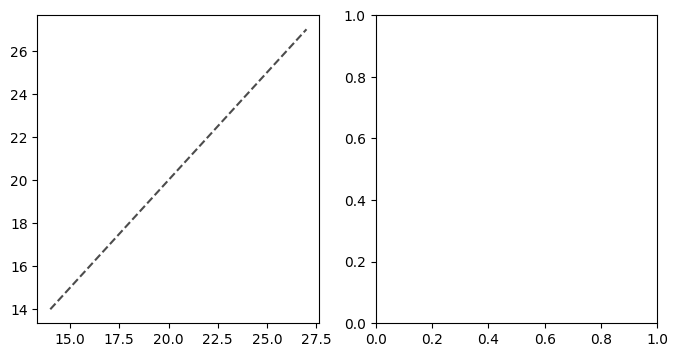

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_test_pred,
    kind="actual_vs_predicted",
    subsample=500,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_train_pred,
    kind="residual_vs_predicted",
    subsample=500,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions | TRAIN")
plt.tight_layout()
plt.show()

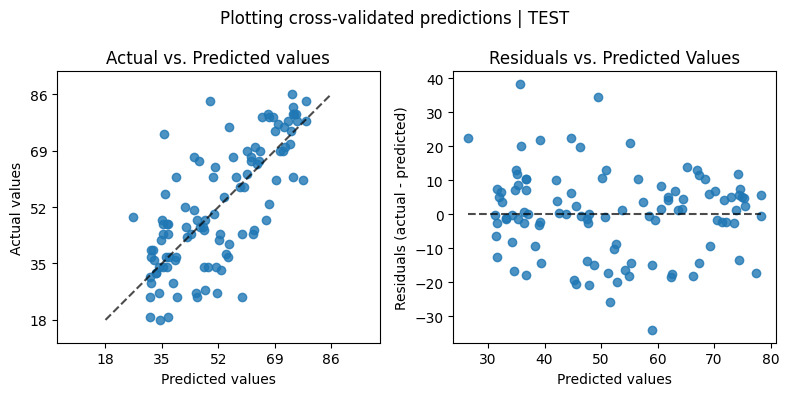

In [78]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred,
    kind="actual_vs_predicted",
    subsample=500,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred,
    kind="residual_vs_predicted",
    subsample=500,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions | TEST")
plt.tight_layout()
plt.show()

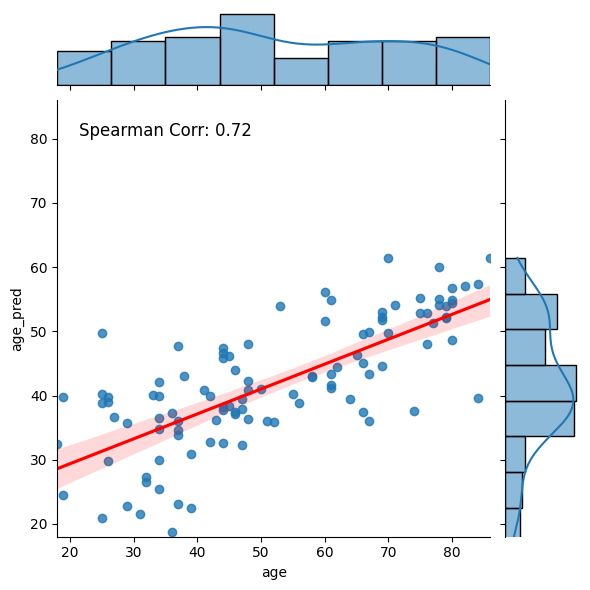

In [83]:
target = "age"
target_pred = "age_pred"
predictions = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1)]

corr, _ = spearmanr(predictions[target], predictions[target_pred])
xmin = predictions[target].min()
xmax = predictions[target].max()
ymin = predictions[f"{target}_pred"].min()
ymax = predictions[f"{target}_pred"].max()

# Create the scatter plot
sns.jointplot(data=predictions, x=target,
              y=target_pred,
              kind="reg",
              line_kws={'color': 'red'},
              xlim=(xmin, xmax),
              ylim=(xmin, xmax)
)

# Annotate the plot with the Spearman correlation coefficient
plt.annotate(f'Spearman Corr: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, color='black')

plt.show()